<a href="https://colab.research.google.com/github/pejmanrasti/NLP/blob/main/4_CNN_surname_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Layer Perceptron (MLP) for Surname Nationality Classification

This notebook demonstrates how to build and train a Multi-Layer Perceptron (MLP) to classify surnames based on their nationalities using a dataset of surnames and corresponding nationalities.

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.layers import Embedding

## Step 2: Load and Preprocess the Data

The dataset is loaded into a Pandas DataFrame. We need to preprocess this data for our neural network.

In [2]:
# Load the dataset
file_path = 'surnames.csv'
surnames_data = pd.read_csv(file_path)

# Display the first few rows
surnames_data.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


### Data Preprocessing

We need to encode the surnames and nationalities into a numerical format. For surnames, we'll convert each character to its ASCII value. For nationalities, we use label encoding.

In [3]:

# Creating a character set and mapping characters to integers
characters = sorted(list(set(''.join(surnames_data['surname']))))
char_to_int = dict((c, i) for i, c in enumerate(characters))

# Function to convert surname to a sequence of integers
def surname_to_int_array(surname):
    return [char_to_int[char] for char in surname if char in char_to_int]

# Convert surnames to sequences of integers
surnames_data['surname_seq'] = surnames_data['surname'].apply(surname_to_int_array)

# Find the length of the longest surname
max_surname_length = max(surnames_data['surname_seq'].apply(len))

# Pad the sequences so that they are all the same length
from keras.preprocessing.sequence import pad_sequences
surnames_data['surname_padded'] = list(pad_sequences(surnames_data['surname_seq'], maxlen=max_surname_length, padding='post'))

# Convert the padded sequences and labels to numpy arrays for training
X = np.array(surnames_data['surname_padded'].tolist())


In [4]:
# Label encode nationalities
label_encoder = LabelEncoder()
surnames_data['nationality_encoded'] = label_encoder.fit_transform(surnames_data['nationality'])

In [5]:
# One-hot encode the nationality labels
y = to_categorical(surnames_data['nationality_encoded'])

## Step 3: Split the Data

We split the data into training, validation, and test sets.

In [6]:

# Stratified Split of the Data
# We use stratified split to ensure representation of each nationality in all datasets

from sklearn.model_selection import StratifiedShuffleSplit

# Creating a StratifiedShuffleSplit object
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Splitting the data - this will only do one split due to n_splits=1
for train_index, temp_index in strat_split.split(X, surnames_data['nationality_encoded']):
    X_train, X_temp = X[train_index], X[temp_index]
    y_train, y_temp = y[train_index], y[temp_index]

# Further split X_temp and y_temp into validation and test sets
strat_split_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_index, test_index in strat_split_val_test.split(X_temp, y_temp.argmax(axis=1)):
    X_val, X_test = X_temp[val_index], X_temp[test_index]
    y_val, y_test = y_temp[val_index], y_temp[test_index]


## Step 4: Build the MLP Model

We build a simple CNN model using Keras.

In [11]:

# Define the CNN model
model = Sequential()
model.add(Embedding(input_dim=len(characters), output_dim=50, input_length=max_surname_length))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 50)            4200      
                                                                 
 conv1d (Conv1D)             (None, 15, 64)            9664      
                                                                 
 max_pooling1d (MaxPooling1  (None, 7, 64)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 128)               57472     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                      

## Step 5: Train the Model

We train the model using the training set and validate it on the validation set.

In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
241/241 [==============================] - 3s 7ms/step - loss: 2.0045 - accuracy: 0.4214 - val_loss: 1.6188 - val_accuracy: 0.5367
Epoch 2/50
241/241 [==============================] - 2s 7ms/step - loss: 1.4851 - accuracy: 0.5814 - val_loss: 1.3081 - val_accuracy: 0.6248
Epoch 3/50
241/241 [==============================] - 2s 6ms/step - loss: 1.2406 - accuracy: 0.6546 - val_loss: 1.1613 - val_accuracy: 0.6661
Epoch 4/50
241/241 [==============================] - 2s 7ms/step - loss: 1.1037 - accuracy: 0.6879 - val_loss: 1.0483 - val_accuracy: 0.7031
Epoch 5/50
241/241 [==============================] - 2s 9ms/step - loss: 1.0106 - accuracy: 0.7100 - val_loss: 0.9964 - val_accuracy: 0.7146
Epoch 6/50
241/241 [==============================] - 2s 10ms/step - loss: 0.9434 - accuracy: 0.7244 - val_loss: 0.9379 - val_accuracy: 0.7341
Epoch 7/50
241/241 [==============================] - 2s 7ms/step - loss: 0.8847 - accuracy: 0.7377 - val_loss: 0.9115 - val_accuracy: 0.7328
Epoch

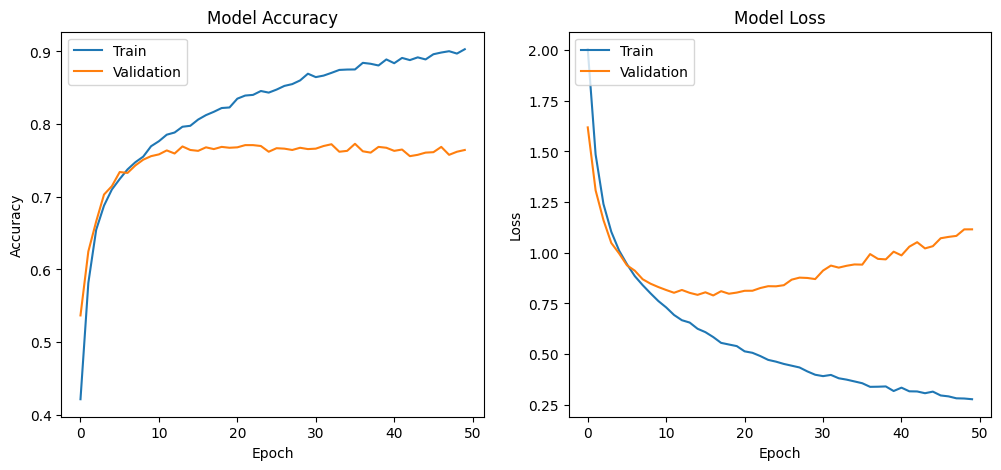

In [13]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


## Step 6: Evaluate the Model

Evaluate the model's performance on the test set.

In [14]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

52/52 [==============================] - 0s 3ms/step - loss: 1.1952 - accuracy: 0.7608
Test Accuracy: 76.08%


## Step 7: Save the Model (Optional)

Optionally, we can save the model for future use.

In [ ]:
# Save the model
model.save('CNN_surname_nationality_classifier.h5')

TODO: Give a surname to the model and ask the model to predict the nationality of it.

TODO: change the architecture of the model to reduce the overfitting